In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import torch

In [7]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/Deep_learning_inverse_problem/HW5/data/"  

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.fft

#import radon
from radon import get_operators

In [9]:
device='cpu' #'cuda' for GPU, 'cpu' otherwise
radon_op, fbp_op = get_operators(n_angles=32, image_size=256, circle=True, device=device)

#forward model representing a radon transform
def A(x):
    y = radon_op(x)
    return y

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


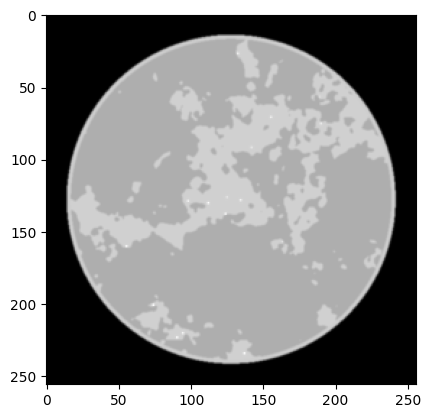

In [10]:
plt.gray()
img = torch.load(data_path+'0')
plt.imshow(img[0])

torch.Size([1, 1, 256, 32])


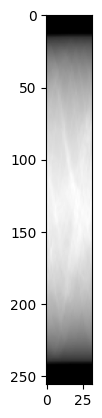

In [11]:
sinogram = A(img.unsqueeze(1))  # unsqueeze because A expects a channel dimension at location 1
print(sinogram.shape)
plt.imshow(sinogram.squeeze())

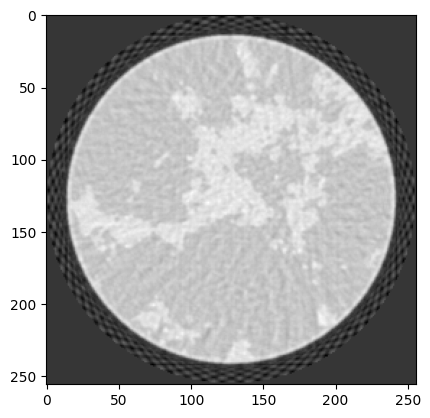

In [12]:
#We use filtered back projection as an estimate of A.T
def AT(y):
    x=fbp_op(y)
    x = x.to(torch.float32)
    return x

reconstruction = AT(sinogram)
plt.imshow(reconstruction.squeeze())

In [13]:
# torch dataset that returns sinograms and ground-truth images
class CTDataSet(torch.utils.data.Dataset):
    
    def __init__(self, path):
        self.path = path

    def __len__(self):
        return len(os.listdir(self.path))
    
    def __getitem__(self, idx):
        img = torch.load(self.path+str(idx)).to(device)
        sino = A(img.unsqueeze(1))
        return img.squeeze(), sino.squeeze()

In [14]:
data_set = CTDataSet(data_path)

#Split dataset into 99 imgs for training and 1 img for validation
train_set, val_set = torch.utils.data.random_split(data_set,[99,1],generator=torch.Generator().manual_seed(0))

#Dataloader
train_dl = DataLoader(train_set, batch_size=1)
val_dl = DataLoader(val_set, batch_size=1)

In [15]:
# fill in code here
# you are free to create as many classes as you need
k = 16
# Define the regularization network
class Regularizer(nn.Module):
    def __init__(self):
        super(Regularizer, self).__init__()
        self.conv1 = nn.Conv2d(1, k, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(k, 1, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out

# Define the variational network
class VarNet(nn.Module):
    def __init__(self, num_cascades=5):
        super(VarNet, self).__init__()
        self.num_cascades = num_cascades
        self.regularizer = Regularizer()
        self.eta = nn.Parameter(torch.tensor([0.01]))  # Trainable parameter eta
        
    def forward(self, y):
        # Initialize x_t
        x_t = AT(y)
        outputs = []
        
        for cascade in range(self.num_cascades):
            #A_x_t = A(x_t.unsqueeze(1))
            A_x_t = A(x_t)
            #residual = A_x_t - y.unsqueeze(1)
            residual = A_x_t - y
            #reg_term = self.regularizer(x_t.unsqueeze(1))
            reg_term = self.regularizer(x_t)
            x_t_plus_1 = x_t - self.eta * (AT(residual) + reg_term)
            outputs.append(x_t_plus_1)
            x_t = x_t_plus_1
        
        return outputs

In [16]:
##Loss
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#train function
def train_step(model, optimizer, dataloader_sample):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()

    # define variables
    x, y = dataloader_sample
      
    # get the prediction
    pred = model(y.unsqueeze(1))[-1].squeeze(1)
    pred_loss = mse(pred, x)
    
    #one step of training
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item()

#test function
def validation_step(model, dataloader_sample): 
    model.eval()
    
    with torch.no_grad(): 
        
        x, y = dataloader_sample
        
        # get the prediction
        pred = model(y.unsqueeze(1))[-1].squeeze(1)
        pred_loss = mse(pred, x)

    return pred_loss.item()

In [17]:
model = VarNet(num_cascades=5)  # Initialize the VarNet model
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)

max_epoch = 10
mse_train=[]
mse_val= []

for epoch in tqdm(range(max_epoch)):
    # Initialize Loss and Accuracy
    train_loss = val_loss= 0.0 # Initialize the losses for the current epoch
    
    ### Training Phase
    
    ## Iterate over the train_dataloader
    with tqdm(total=len(train_dl)) as pbar:
        for sample in train_dl:            
            curr_loss = train_step(model, optimizer, sample)
            train_loss += curr_loss / len(train_dl) 
            pbar.update(1)
    
    mse_train.append(train_loss)


    ### Validation Phase 
    
    ## Validation_dataloader
    with tqdm(total=len(val_dl)) as pbar:
        for sample in val_dl: 
            curr_loss = validation_step(model, sample)
            val_loss += curr_loss / len(val_dl)
            pbar.update(1)
    
    mse_val.append(val_loss) 
    
    print(epoch, train_loss, val_loss)    


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 0.0008500157102867207 0.0006293213809840381


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.0004723776596941694 0.000378370750695467


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.00033092997792397963 0.0003126611409243196


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.0002839739878033994 0.0002772978332359344


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.0002565549326721917 0.0002541920111980289


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.00023661766361769725 0.0002378086355747655


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.00022199866545652368 0.00022582140809390694


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

7 0.000211801112472489 0.00021764895063824952


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

8 0.00020473502515203724 0.00021169513638596982


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.0001998672048994012 0.00020783394575119019


Text(0, 0.5, 'MSE')

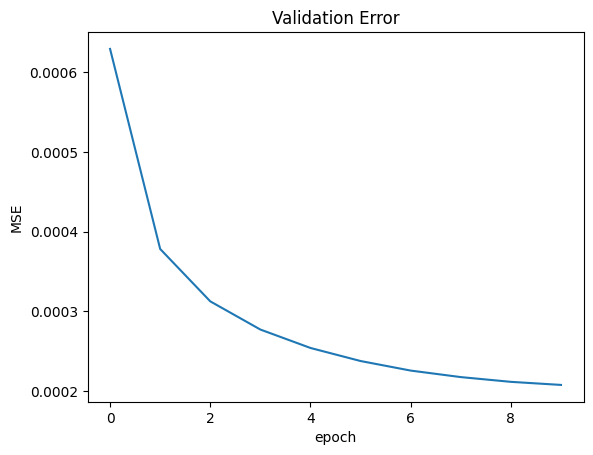

In [18]:
plt.plot(mse_val)
plt.title('Validation Error')
plt.xlabel('epoch')
plt.ylabel('MSE')

### Visualization how VarNet reconstructs an image

Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

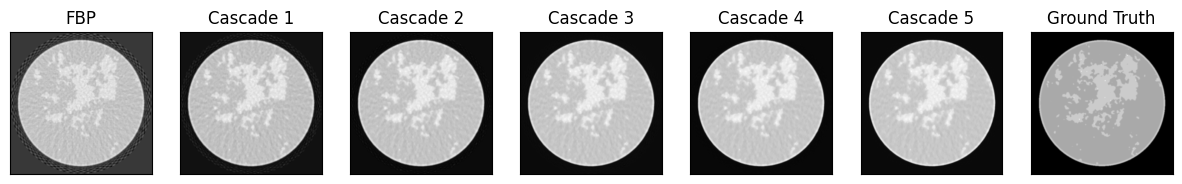

In [19]:
sample=next(iter(val_dl))  #img from val set

#reconstruction
with torch.no_grad(): 
    x, y = sample
    pred = model(y.unsqueeze(1))
    fbp = AT(y.unsqueeze(1))

plt.gray()
fig, ax = plt.subplots(1, 7,figsize=(15, 15))

ax[0].imshow(fbp.squeeze().cpu())
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('FBP') 

for i in range(5):
    ax[i+1].imshow(pred[i].squeeze().cpu())
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_title('Cascade '+ str(i+1))
    
ax[6].imshow(x.squeeze().cpu())   
ax[6].set_xticks([])
ax[6].set_yticks([])
ax[6].set_title('Ground Truth')  